In [4]:
import os
import xarray as xr
import pandas as pd
import netCDF4 as nc
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt
import gc
import os 
from os.path import exists
import dask_labextension
import numpy as np
import xarray as xr

In [5]:
def plotsdir(x = ""): 
    return "/scratch/anthony.meza/CM4X/CM4XTransientTracers/figures" + x

In [6]:
import gsw, xwmt, xgcm
import cmocean.cm as cm

In [7]:
# from dask_jobqueue import SLURMCluster  # setup dask cluster 
# cluster = SLURMCluster(
#     cores=36,
#     processes=1,
#     memory='40GB',
#     walltime='02:00:00',
#     queue='scavenger',
#     interface='ib0')
# print(cluster.job_script())
# cluster.scale(jobs=16)
# from dask.distributed import Client
# client = Client(cluster)

In [8]:
# client

In [9]:
def get_sigma2(ds, keep_vars = False): 
    ds['p'] = xr.apply_ufunc(
        gsw.p_from_z, ds.z, ds.lat, 0, 0, dask="parallelized"
    )


    ds['sa'] = xr.apply_ufunc(
        gsw.SA_from_SP,
        ds.so,
        ds.p,
        ds.lon,
        ds.lat,
        dask="parallelized",
    )
    ds['ct'] = xr.apply_ufunc(
        gsw.CT_from_t,
        ds.sa,
        ds.thetao,
        ds.p,
        dask="parallelized"
    )

    ds['sigma2'] = xr.apply_ufunc(
        gsw.sigma2,
        ds.sa,
        ds.ct,
        dask="parallelized"
    )
    if keep_vars: 
        return ds
    else: 
        return ds.drop_vars(["p", "sa", "ct"])

In [10]:
def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1, "time":-1, "depth":2},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

In [11]:
CM4Xp25_historical = read_CM4X("../../CM4Xp25_historical_transient_tracers.zarr")
CM4Xp25_ssp585 = read_CM4X("../../CM4Xp25_ssp585_transient_tracers.zarr")
CM4Xp25_piControl = read_CM4X("../../CM4Xp25_piControl_transient_tracers.zarr")

In [12]:
CFC_12_C = xr.open_mfdataset("../../CimoliData/CFC.nc")
CFC_11_C = xr.open_mfdataset("../../CimoliData/CFC11.nc")
SF6_C = xr.open_mfdataset("../../CimoliData/SF6.nc")

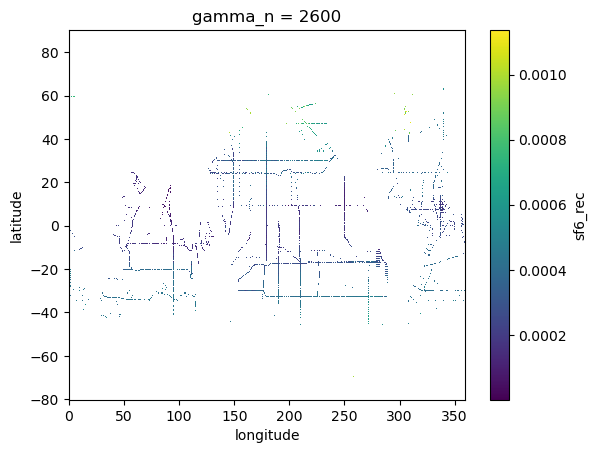

In [13]:
SF6_C.sel(gamma_n = 2600, method = "nearest").mean("time").sf6_rec.plot()

In [34]:
ds = CM4Xp25_historical.sel(year = slice(2000, 2014)).sel(xh = slice(-124, -118))
ds = get_sigma2(ds).compute()
_, y = np.meshgrid(ds.zl, ds.isel(xh = 0).geolat) # broadcast latitude
# ds = ds.mean("year").mean("xh")
ds = (ds * ds.thkcello).sum("xh") /  ds.thkcello.sum("xh")
ds = ds.mean("year")
z = ds.sigma2.compute() # broadcast vertical coordinate to two-dimensional mesh
# # ds = ds * np.isnan(z.values)
z.values[np.isnan(z.values)] = 0

In [35]:
def subset_cimoli(ds):
    ds = ds.sel(time = slice(2000, 2014)).sel(longitude = slice(176, 182))
    return ds.mean(["time", "longitude"])

In [36]:
CFC12_subset = subset_cimoli(CFC_12_C).cfc12_rec.compute()
CFC11_subset = subset_cimoli(CFC_11_C).cfc11_rec.compute()
SF6_subset = subset_cimoli(SF6_C).sf6_rec.compute()

In [37]:
data_y = CFC12_subset.gamma_n/ 100 #
data_x = CFC12_subset.latitude


In [38]:
import matplotlib.ticker as ticker
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


/tmp/ipykernel_227314/2079424313.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(y,z.T,ds.cfc12.transpose() * 1e9, vmin = 0, vmax = 3, shading = "nearest")
/tmp/ipykernel_227314/2079424313.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(y,z.T,ds.cfc11.transpose()  * 1e9, vmin = 0, vmax = 3, shading = "nearest")
/tmp/ipykernel_227314/2079424313.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in wh

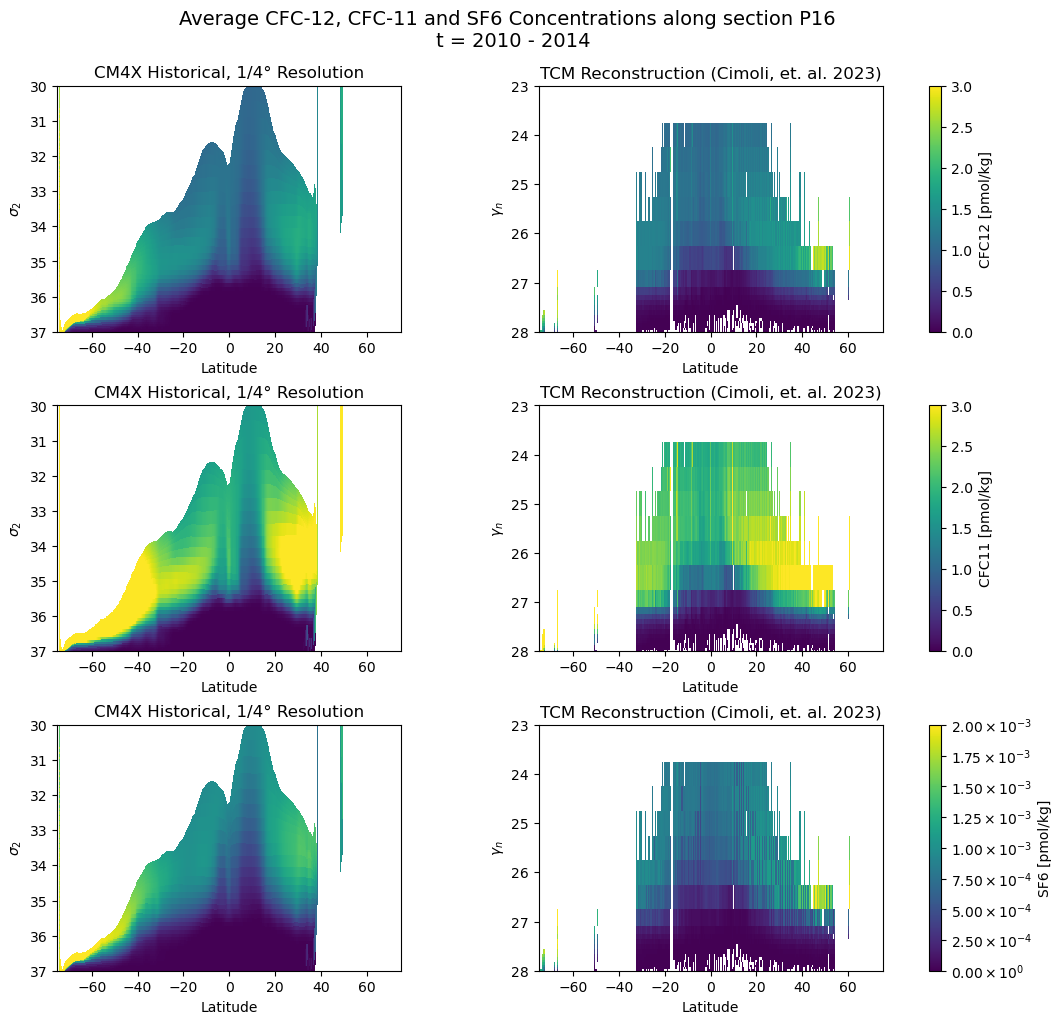

In [39]:
fig, axes = plt.subplots(3,2,figsize=(10, 10), sharey = False)
fig.suptitle("Average CFC-12, CFC-11 and SF6 Concentrations along section P16 \n t = 2010 - 2014", fontsize = 14, y = 1, x = 0.5)

fig.tight_layout()
fig.subplots_adjust(wspace = 0.4, hspace = 0.3)


[a.set_ylim(23, 28) for a in axes[:, 1].flatten()]
[a.set_ylim(30, 37) for a in axes[:, 0].flatten()]
[a.set_xlim(-75, 75) for a in axes.flatten()]


ax = axes[0, :]
ax[0].pcolormesh(y,z.T,ds.cfc12.transpose() * 1e9, vmin = 0, vmax = 3, shading = "nearest")
cm = ax[1].pcolormesh(data_x,data_y ,CFC12_subset, vmin = 0, vmax = 3, shading = "nearest")
fig.colorbar(cm, ax = ax[:], label = "CFC12 [pmol/kg]", orientation = "vertical", fraction = 0.06)
[a.invert_yaxis() for a in ax[:]]
ax[0].set_title("CM4X Historical, 1/4° Resolution")
ax[1].set_title("TCM Reconstruction (Cimoli, et. al. 2023)")
ax[0].set_ylabel(r"$\sigma_2$")
ax[1].set_ylabel(r"$\gamma_n$")

ax = axes[1, :]
ax[0].pcolormesh(y,z.T,ds.cfc11.transpose()  * 1e9, vmin = 0, vmax = 3, shading = "nearest")
cm = ax[1].pcolormesh(data_x,data_y ,CFC11_subset, vmin = 0, vmax = 3, shading = "nearest")
fig.colorbar(cm, ax = ax[:], label = "CFC11 [pmol/kg]", orientation = "vertical", fraction = 0.06)

[a.invert_yaxis() for a in ax[:]]
ax[0].set_title("CM4X Historical, 1/4° Resolution")
ax[1].set_title("TCM Reconstruction (Cimoli, et. al. 2023)")
ax[0].set_ylabel(r"$\sigma_2$")
ax[1].set_ylabel(r"$\gamma_n$")

ax = axes[2, :]
ax[0].pcolormesh(y,z.T,ds.sf6.transpose()  * 1e9, vmin = 0, vmax = 0.002, shading = "nearest")
cm = ax[1].pcolormesh(data_x,data_y ,SF6_subset, vmin = 0, vmax = 0.002, shading = "nearest")
fig.colorbar(cm, ax = ax[:], label = "SF6 [pmol/kg]", orientation = "vertical", fraction = 0.06, format=ticker.FuncFormatter(fmt))

[a.invert_yaxis() for a in ax[:]]
ax[0].set_title("CM4X Historical, 1/4° Resolution")
ax[1].set_title("TCM Reconstruction (Cimoli, et. al. 2023)")
ax[0].set_ylabel(r"$\sigma_2$")
ax[1].set_ylabel(r"$\gamma_n$")



[a.set_xlabel("Latitude") for a in axes.flatten()];
fig.savefig(plotsdir(), dpi = 400)